# Obtain non-zero median expression value of each gene across Genecorpus-30M

#### Upon request, we are providing the code that we used for obtaining the non-zero median expression value of each gene across the broad range of cell types represented in Genecorpus-30M that we use as a normalization factor to prioritize genes that uniquely distinguish cell state.

#### Please read the important information below before using this code.

#### If using Geneformer, to ensure consistency of the normalization factor used for each gene for all future datasets,  <ins>**users should use the Geneformer transcriptome tokenizer to tokenize their datasets and should not re-calculate this normalization factor for their individual dataset** </ins>. This code for re-calculating the normalization factor should only be used by users who are pretraining a new model from scratch with a new pretraining corpus other than Genecorpus-30M.

#### It is critical that this calculation is performed on a large-scale pretraining corpus that has tens of millions of cells from a broad range of human tissues.  <ins>**The richness of variable cell states in the pretraining corpus is what allows this normalization factor to accomplish the goal of prioritizing genes that uniquely distinguish cell states.** </ins> This normalization factor for each gene is calculated once from the large-scale pretraining corpus and is used for all future datasets presented to the model. 

#### Of note, as discussed in the Methods, we only included droplet-based sequencing platforms in the pretraining corpus to assure expression value unit comparability for the calculation of this normalization factor. Users wishing to pretrain a new model from scratch with a new pretraining corpus should choose either droplet-based or plate-based platforms for calculating this normalization factor, or they should exercise caution that including both platforms may cause unintended effects on the results. Once the normalization factor is calculated however, data from any platform can be used with the model because the expression value units will be consistent within each individual cell.

#### Please see the Methods in the manuscript for a description of the procedure enacted by this code, an excerpt of which is below for convenience:

#### "To accomplish this, we first calculated the non-zero median value of expression of each detected gene across all cells passing quality filtering from the entire Genecorpus-30M. We aggregated the transcript count distribution for each gene in a memory-efficient manner by scanning through chunks of .loom data using loompy, normalizing the gene transcript counts in each cell by the total transcript count of that cell to account for varying sequencing depth and updating the normalized count distribution of the gene within the t-digest data structure developed for accurate online accumulation of rank-based statistics. We then normalized the genes in each single-cell transcriptome by the non-zero median value of expression of that gene across Genecorpus-30M and ordered the genes by the rank of their normalized expression in that specific cell. Of note, we opted to use the non-zero median value of expression rather than include zeros in the distribution so as not to weight the value by tissue representation within Genecorpus-30M, assuming that a representative range of transcript values would be observed within the cells in which each gene was detected. This normalization factor for each gene is calculated once from the pretraining corpus and is used for all future datasets presented to the model. The provided tokenizer code includes this normalization procedure and should be used for tokenizing new datasets presented to Geneformer to ensure consistency of the normalization factor used for each gene."

In [1]:
import os
import numpy as np
import loompy as lp
import pandas as pd
import crick
import pickle
import math
from tqdm.notebook import tqdm

### The following code is an example of how the nonzero median expression values are obtained for a single input file. This calculation should be run as a script to be parallelized for all dataset files.

In [30]:
input_file = "study1.loom"
current_database = "database1"

rootdir = f"/path/to/{current_database}/data/"
output_file = input_file.replace(".loom", ".gene_median_digest_dict.pickle")
outdir = rootdir.replace("/data/", "/tdigest/")

with lp.connect(f"{rootdir}{input_file}") as data:
    # define coordinates of protein-coding or miRNA genes
    coding_miRNA_loc = np.where((data.ra.gene_type == "protein_coding") | (data.ra.gene_type == "miRNA"))[0]
    coding_miRNA_genes = data.ra["ensembl_id"][coding_miRNA_loc]
    
    # initiate tdigests
    median_digests = [crick.tdigest.TDigest() for _ in range(len(coding_miRNA_loc))]
    
    # initiate progress meters
    progress = tqdm(total=len(coding_miRNA_loc))
    last_view_row = 0
    progress.update(0)
    
    for (ix, selection, view) in data.scan(items=coding_miRNA_loc, axis=0):
        # define coordinates of cells passing filter
        filter_passed_loc = np.where(view.ca.filter_pass == 1)[0]
        subview = view.view[:, filter_passed_loc]
        # normalize by total counts per cell and multiply by 10,000 to allocate bits to precision
        subview_norm_array = subview[:,:]/subview.ca.n_counts*10_000
         # if integer, convert to float to prevent error with filling with nan
        if np.issubdtype(subview_norm_array.dtype, np.integer):
            subview_norm_array = subview_norm_array.astype(np.float32)
        # mask zeroes from distribution tdigest by filling with nan
        nonzero_data = np.ma.masked_equal(subview_norm_array, 0.0).filled(np.nan)
        # update tdigests
        [median_digests[i+last_view_row].update(nonzero_data[i,:]) for i in range(nonzero_data.shape[0])]
        # update progress meters
        progress.update(view.shape[0])
        last_view_row = last_view_row + view.shape[0]
        
median_digest_dict = dict(zip(coding_miRNA_genes, median_digests))
with open(f"{outdir}{output_file}", "wb") as fp:
    pickle.dump(median_digest_dict, fp)

### After the above code is run as a script in parallel for all datasets to obtain the nonzero median tdigests for their contained genes, the following code can be run to merge the tdigests across all datasets.

In [2]:
# merge new tdigests into total tdigest dict
def merge_digest(dict_key_ensembl_id, dict_value_tdigest, new_tdigest_dict):
    new_gene_tdigest = new_tdigest_dict.get(dict_key_ensembl_id)
    if new_gene_tdigest is not None:
        dict_value_tdigest.merge(new_gene_tdigest)
        return dict_value_tdigest
    elif new_gene_tdigest is None:
        return dict_value_tdigest

In [ ]:
# use tdigest1.merge(tdigest2) to merge tdigest1, tdigest2, ...tdigestn
# then, extract median by tdigest1.quantile(0.5)

databases = ["database1", "database2", "...databaseN"]

# obtain gene list
gene_info = pd.read_csv("/path/to/gene_info_table.csv", index_col=0)
func_gene_list = [i for i in gene_info[(gene_info["gene_type"] == "protein_coding") | (gene_info["gene_type"] == "miRNA")]["ensembl_id"]]

# initiate tdigests
median_digests = [crick.tdigest.TDigest() for _ in range(len(func_gene_list))]
total_tdigest_dict = dict(zip(func_gene_list, median_digests))

# merge tdigests
for current_database in databases:
    rootdir = f"/path/to/{current_database}/tdigest/"
    
    for subdir, dirs, files in os.walk(rootdir):	
        for file in files:
            if file.endswith(".gene_median_digest_dict.pickle"):
                with open(f"{rootdir}{file}", "rb") as fp:
                    tdigest_dict = pickle.load(fp)
                total_tdigest_dict = {k: merge_digest(k,v,tdigest_dict) for k, v in total_tdigest_dict.items()}

# save dict of merged tdigests
with open(f"/path/to/total_gene_tdigest_dict.pickle", "wb") as fp:
    pickle.dump(total_tdigest_dict, fp)

# extract medians and save dict
total_median_dict = {k: v.quantile(0.5) for k, v in total_tdigest_dict.items()}
with open(f"/path/to/total_gene_median_dict.pickle", "wb") as fp:
    pickle.dump(total_median_dict, fp)

# save dict of only detected genes' medians    
detected_median_dict = {k: v for k, v in total_median_dict.items() if not math.isnan(v)}
with open(f"/path/to/detected_gene_median_dict.pickle", "wb") as fp:
    pickle.dump(detected_median_dict, fp)

### The below code displays some characteristics of the genes detected in the pretraining corpus.

In [38]:
gene_detection_counts_dict = {k: v.size() for k, v in total_tdigest_dict.items()}

/home1/ct68/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


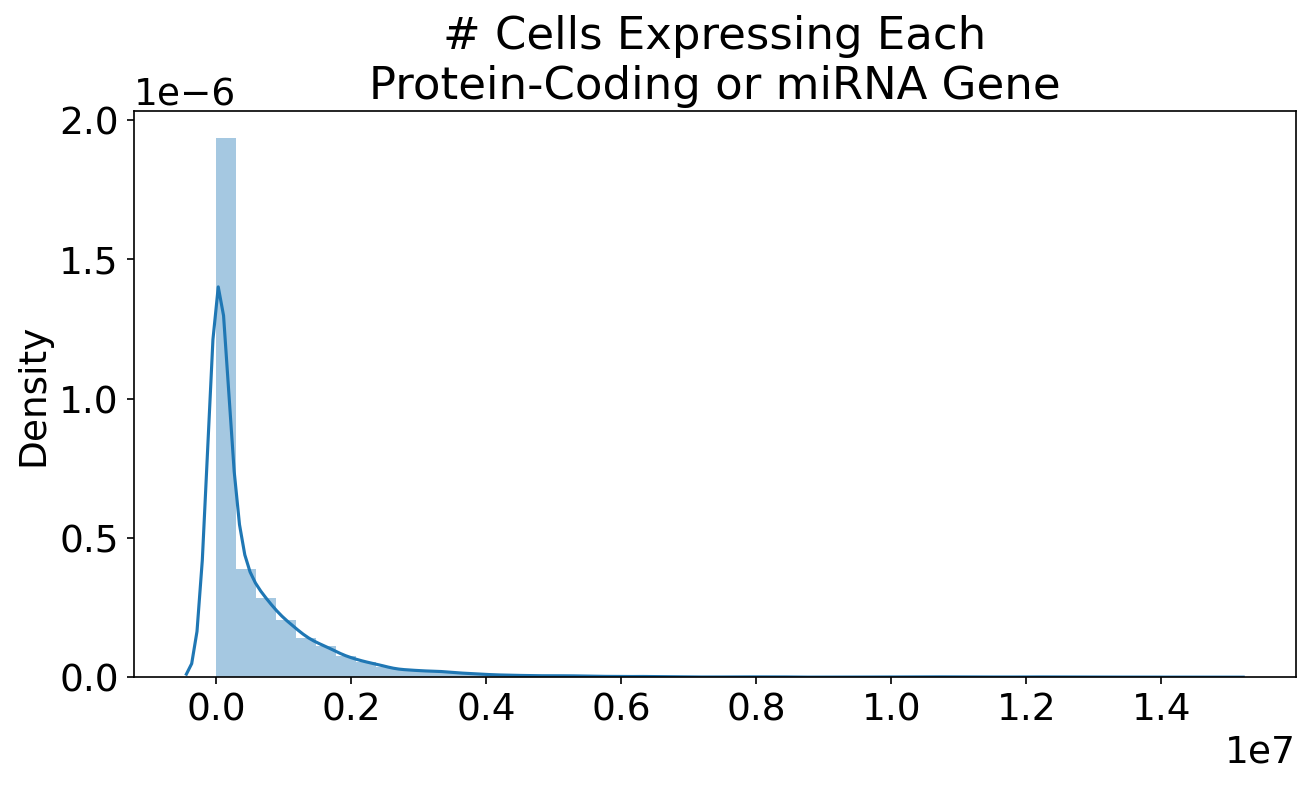

In [44]:
gene_detection_counts = [i for i in gene_detection_counts_dict.values()]
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5), dpi=150)
plt.rcParams.update({'font.size': 18})
count_plot = sns.distplot(gene_detection_counts).set_title(f"# Cells Expressing Each\nProtein-Coding or miRNA Gene")

In [47]:
len(gene_detection_counts)

27454

In [55]:
len([i for i in gene_detection_counts if i > 0])

25424

In [56]:
len([i for i in gene_detection_counts if i > 100])

22735

In [57]:
len([i for i in gene_detection_counts if i > 1000])

21167

In [49]:
gene_detection_event_digest = crick.tdigest.TDigest()
gene_detection_event_digest.update(gene_detection_counts)
gene_detection_event_digest.quantile(0.5)

173152.0299000284